# Read and parse ROI_PAC-style header keys/values from .rsc files

In [6]:
import os
import sys
import numpy as np

def roipac_info():
    """Return default ROI_PAC-style header keys/values (strings)."""
    info = {}
    info['ACQTIME']     = 'NONE'
    info['MTIME']       = 'NONE'
    info['STIME']       = 'NONE'
    info['SUPERMASTER'] = 'NONE'
    info['REFLON']      = 'NONE'
    info['REFLAT']      = 'NONE'
    info['MODE']        = 'NONE'
    info['LOOP_FILES']  = 'NONE'
    info['LOOP_SIGNS']  = 'NONE'
    info['Z_SHIFT']     = 'NONE'
    info['WIDTH']       = '0'
    info['FILE_LENGTH'] = '0'
    info['X_MAX']       = '0'
    info['Y_MIN']       = '0'
    info['X_STEP']      = '1'
    info['Y_STEP']      = '-1'
    info['X_FIRST']     = '0'
    info['Y_FIRST']     = '0'
    info['RNG_SPACING'] = '0'
    info['AZI_SPACING'] = '0'
    info['INCIDENCE']   = '0'
    info['PERPB']       = '0'
    info['TEMPB']       = '0'
    info['WAVELENGTH']  = '0.05554'
    info['HEADING_DEG'] = '0'
    info['SENSOR']      = 'SAR'
    info['SENSOR_M']    = 'SAR'
    info['SENSOR_S']    = 'SAR'
    info['X_UNIT']      = 'DEG'
    info['Z_MIN']       = 'NONE'
    info['Z_MAX']       = 'NONE'
    info['UNIT']        = 'NONE'
    info['Y_UNIT']      = 'DEG'
    info['MASTER']      = "NONE"
    info['SLAVE']       = "NONE"
    info['POL_MASTER']  = 'NONE'
    info['POL_SLAVE']   = 'NONE'
    info['POLARISATION']= "NONE"
    info["POINTINGDIR"] = "NONE"
    info["PROJECTION"]  = "LL"
    info['TRACK']       = 'NONE'
    return info, list(info.keys())

def rsc_read(rsc, ll180=False):
    """Read a .rsc into dict and return (info, extent=[xmin,xmax,ymin,ymax])."""
    roiinfo, keys = roipac_info()
    roiinfo["SENSOR"] = 0  # keep compatibility with original code

    if not os.path.exists(rsc):
        print(f" ERROR: {rsc} does not exist.")
        return False, False

    counter_info = {k: 0 for k in roiinfo.keys()}
    with open(rsc, 'r', encoding='iso-8859-1') as fid:
        for line in fid:
            parts = line.strip().split()
            if not parts:
                continue
            key = parts[0]
            val = parts[1] if len(parts) > 1 else ""

            # allow unknown keys
            if key not in roiinfo:
                roiinfo[key] = val
                counter_info[key] = 0

            # keep the longest value seen for a key
            if counter_info[key] == 0:
                roiinfo[key] = val
            else:
                if len(val) > len(str(roiinfo[key])):
                    roiinfo[key] = val
            counter_info[key] += 1

    # fill empties
    for k, default in [('X_FIRST', "0"), ('X_STEP', "1"),
                       ('Y_FIRST', "0"), ('Y_STEP', "1")]:
        if str(roiinfo.get(k, "")).strip() == "":
            roiinfo[k] = default

    xmin   = float(roiinfo['X_FIRST'])
    width  = int(roiinfo['WIDTH'])
    xpos   = float(roiinfo['X_STEP'])
    xmax   = xmin + (width - 1) * xpos

    ymax   = float(roiinfo['Y_FIRST'])
    length = int(roiinfo['FILE_LENGTH'])
    ypos   = float(roiinfo['Y_STEP'])
    ymin   = ymax + (length - 1) * ypos
    extent = [xmin, xmax, ymin, ymax]

    roiinfo['X_MAX'] = str(xmax)
    roiinfo['Y_MIN'] = str(ymin)

    # optional longitude wrap
    if ll180 and float(roiinfo['X_FIRST']) > 180:
        roiinfo['X_FIRST'] = float(roiinfo['X_FIRST']) - 360.0
        xmin = float(roiinfo['X_FIRST'])
        xmax = xmin + (width - 1) * xpos
        extent = [xmin, xmax, ymin, ymax]

    # stringify all to keep legacy behavior
    for k in roiinfo.keys():
        roiinfo[k] = str(roiinfo[k]).replace(" ", "")

    return roiinfo, extent

def rsc_to_llm(rsc, model=0, scale=1, ll180=False):
    """Return lon/lat matrices from .rsc (ROI_PAC style)."""
    info, ext = rsc_read(rsc, ll180=ll180)
    width       = int(info['WIDTH'])
    file_length = int(info['FILE_LENGTH'])

    min_lon = np.float32(info['X_FIRST'])
    max_lon = np.float32(info['X_STEP']) * (width - 1) + min_lon
    lonV    = np.linspace(min_lon, max_lon, num=width, dtype='float32')

    max_lat = np.float32(info['Y_FIRST'])
    min_lat = np.float32(info['Y_STEP']) * (file_length - 1) + max_lat
    latV    = np.flipud(np.linspace(min_lat, max_lat, num=file_length, dtype='float32'))

    lonM = np.repeat([lonV], file_length, axis=0)
    latM = np.repeat([latV], width, axis=0).T

    if scale > 1:
        lonM = lonM[::scale, ::scale]
        latM = latM[::scale, ::scale]

    if model == 0:
        return lonM, latM
    else:
        return lonM.ravel(), latM.ravel()

def roi_to_lines(inphs, dtype='float32', band=1, dims=None):
    """Infer number of lines from file size and width (from .rsc if dims is None)."""
    # byte-per-pixel
    dtype_up = dtype.upper()
    if dtype_up in ("FLOAT32", ">F4"):
        bpp = 4
    elif dtype_up in ("FLOAT64", ">F8"):
        bpp = 8
    elif dtype_up in ("INT16", "I4", ">I4"):
        bpp = 2
    elif dtype_up == "INT8":
        bpp = 1
    else:
        # fallback
        bpp = 4

    fsize = os.path.getsize(inphs)
    if dims is None:
        info, _ = rsc_read(inphs + '.rsc')
        width = int(info["WIDTH"])
    else:
        width = dims

    lines = fsize / (width * bpp * band)
    return int(lines)

def roi_to_fmt(inphs, dims=None, band=1):
    """Detect file dtype by file size vs pixels from .rsc (or provided dims)."""
    fsize = os.path.getsize(inphs)
    if dims is not None:
        width, file_length = dims[0], dims[1]
    else:
        info, _ = rsc_read(inphs + '.rsc')
        width = int(info['WIDTH'])
        file_length = int(info['FILE_LENGTH'])

    pixels = width * file_length * band
    per_pixel = int(float(fsize) / pixels)

    if per_pixel == 4:
        return 'float32'
    elif per_pixel == 8:
        return 'float64'
    elif per_pixel == 2:
        return 'int16'
    else:
        return 'int8'

def roi_read(roi_file, dtype=None, isplot=0, dims=None, band=1,
             scale=1, ingamma=False, iscomplex=False, is_z_shift=False):
    """
    Read ROI_PAC-like binary file with .rsc sidecar.
    Returns a 2D numpy array (float32 by default).
    """
    rsc = roi_file + '.rsc'

    # decide dtype
    if dtype is None:
        if ingamma:
            dtype = ">f4"
        else:
            dtype = roi_to_fmt(roi_file, dims=dims)

    if os.path.exists(rsc):
        info, ext = rsc_read(rsc)
        nx = int(info['WIDTH'])
        ny = int(info['FILE_LENGTH'])
        z_shift = info.get('Z_SHIFT', 'NONE')
    else:
        z_shift = 'NONE'
        if dims is None:
            print(" pSAR.ROIPAC: ERROR -> No dimensions are provided and .rsc missing")
            sys.exit(-1)
        else:
            nx, ny = dims[0], dims[1]

    # sanity: recompute lines from file size
    lines = roi_to_lines(roi_file, dtype=dtype, band=band, dims=None if dims is None else dims[0])
    if lines != ny:
        print(f" WARNING: {roi_file} has {lines} lines (rsc says {ny}); using {lines}")
        ny = int(lines)

    data = np.fromfile(roi_file, dtype=dtype, count=int(nx * ny * band), sep="")
    if not iscomplex:
        data = data.reshape([ny, band, nx])
    else:
        data = data.reshape([ny, nx, band])

    # select band and downscale
    if not iscomplex:
        arr = data[::scale, 0, ::scale] if band == 1 else data[::scale, 1, ::scale]
    else:
        pwr  = data[::scale, ::scale, 0]
        imag = data[::scale, ::scale, 1]
        arr  = np.arctan2(imag, pwr)

    # optional Z shift
    if is_z_shift and str(z_shift).upper() != "NONE":
        mask = (arr != 0)
        arr[mask] = arr[mask] - float(z_shift)

    return arr


# Load an interferogram stack and retrieve its spatial extent and resolution


In [7]:
import numpy as np
from pathlib import Path
import sarxarray
# Path to the interferogram dataset
# path = Path(cwd / 'data/nl_amsterdam_s1_asc_t088')
path = Path('./nl_amsterdam_s1_asc_t088')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p for p in path.rglob('*_cint_srd.raw')]
list_slcs.sort()

# Metadata of the stack, assume known.
shape=(2000, 4000)

# Define reading chunks
reading_chunks = (2000,4000)

list_slcs
# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=np.complex64, chunks=reading_chunks)
# Geo-referenced coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

# Load coordinates
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
lon_min = float(stack.coords['lon'].min().compute())
lon_max = float(stack.coords['lon'].max().compute())
lat_min = float(stack.coords['lat'].min().compute())
lat_max = float(stack.coords['lat'].max().compute())
print("Lon min:", lon_min, "Lon max:", lon_max)
print("Lat min:", lat_min, "Lat max:", lat_max)

lon_da = lon['lon']   # Dataset → DataArray
lat_da = lat['lat']
print(lon_da.isel(azimuth=0, range=1).compute())
print(lon_da.isel(azimuth=0, range=0).compute())
lon_res = float((lon_da.isel(azimuth=0, range=1) - lon_da.isel(azimuth=0, range=0)).compute())

lat_res = float((lat_da.isel(azimuth=1, range=0) - lat_da.isel(azimuth=0, range=0)).compute())
print(lon_res, lat_res)

Lon min: 4.731956481933594 Lon max: 5.038195610046387
Lat min: 52.23128128051758 Lat max: 52.50313186645508
<xarray.DataArray 'lon' (time: 1)> Size: 4B
memmap([4.808728], dtype=float32)
Coordinates:
    azimuth  int64 8B 0
    range    int64 8B 1
  * time     (time) int64 8B 0
<xarray.DataArray 'lon' (time: 1)> Size: 4B
memmap([4.808672], dtype=float32)
Coordinates:
    azimuth  int64 8B 0
    range    int64 8B 0
  * time     (time) int64 8B 0
5.626678466796875e-05 0.0001220703125


# Retrieve the acquisition dates of the SAR images, then download the corresponding GACOS products from http://www.gacos.net/

In [8]:
date_list = [p.name.split('_')[0] for p in list_slcs]
date_list = np.array(date_list)
print(date_list)
for date in date_list:
    print(date)

['20180920' '20180926' '20181002' '20181008' '20181014' '20181020'
 '20181026' '20181101' '20181107' '20181113']
20180920
20180926
20181002
20181008
20181014
20181020
20181026
20181101
20181107
20181113


# Specify the master acquisition and retrieve the APS

In [9]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

def interp_byrsc(inroi_ztd, stack, lon_ds, lat_ds, method='linear'):
    """
    Interpolate GACOS ZTD/ROI data onto the target grid defined by stack coordinates.

    Parameters
    ----------
    inroi_ztd : str
        Path to the source ROI/ZTD file (e.g., '/path/20181014.ztd').
        A matching '.rsc' file is expected at '<inroi_ztd>.rsc'.
    stack : xarray.Dataset
        Dataset containing 2-D 'lon' and 'lat' DataArrays defining the target grid.
    lon_ds, lat_ds : xarray.Dataset or Mapping
        Objects containing DataArrays 'lon' and 'lat'. 
        Typically: stack[['lon']], stack[['lat']].
    method : {'linear', 'nearest', 'cubic'}
        Interpolation method for scipy.interpolate.griddata.

    Returns
    -------
    outdata : (ny, nx) float32 array
        Interpolated data with NaN for invalid pixels.
    Olon, Olat : (ny, nx) float32 arrays
        Target longitude and latitude mesh grids.
    """
    # --- Read source grid (lon/lat) and data ---
    lonm, latm = rsc_to_llm(inroi_ztd + '.rsc')   # Read grid from .rsc
    data = roi_read(inroi_ztd).astype('float32')  # Read ZTD/ROI raster

    # Keep NaN as invalid mask; do not replace with 0

    # --- Extract target grid from lon/lat datasets ---
    lon_da = lon_ds['lon']
    lat_da = lat_ds['lat']
    Olon = np.asarray(lon_da.squeeze().values, dtype='float32')
    Olat = np.asarray(lat_da.squeeze().values, dtype='float32')

    # --- Flatten source data and remove NaNs ---
    lon1 = lonm.ravel().astype('float32')
    lat1 = latm.ravel().astype('float32')
    val1 = data.ravel().astype('float32')

    valid = np.isfinite(val1)
    if not np.any(valid):
        # No valid data at all — return full NaN array
        out = np.full_like(Olon, np.nan, dtype='float32')
        return out, Olon, Olat

    ipts = np.column_stack([lon1[valid], lat1[valid]])

    # --- Interpolate to target grid ---
    outdata = griddata(ipts, val1[valid], (Olon, Olat),
                       method=method, fill_value=np.nan)
    outdata = outdata.astype('float32')

    return outdata, Olon, Olat


# ===== Parameters (these should be provided by your external context) =====
# stack: xarray.Dataset with 2D lon/lat (dims usually ('azimuth','range'))
# date_list: list[str] of all acquisition dates (e.g., '20181014')
# GACOS_DIR: directory containing GACOS ZTD files
# wvl: radar wavelength (meters)

# Example values if not provided externally:
GACOS_DIR = "gacos"
wvl = 0.05554
theta = 35
theta_rad = np.deg2rad(theta) 
d1 = date_list[0]


# Get dimension names from the lon DataArray
dims_yx = tuple(stack['lon'].dims)  # e.g., ('azimuth','range')
if len(dims_yx) != 2:
    raise ValueError(f"'lon' must be 2D with 2 dims, got {dims_yx}")

lon_ds = stack[['lon']]
lat_ds = stack[['lat']]

results = []
slave_dates = []
Olon_last, Olat_last = None, None

for d2 in date_list:
    if d2 == d1:
        continue

    m_ztd = os.path.join(GACOS_DIR, f"{d1}.ztd")
    s_ztd = os.path.join(GACOS_DIR, f"{d2}.ztd")


    if not (os.path.isfile(m_ztd) and os.path.isfile(s_ztd)):
        print(f"⚠ Missing ZTD file: {m_ztd} or {s_ztd}, skipping {d1}-{d2}")
        continue

    print(f"Processing Master: {d1}, Slave: {d2}")

    aps1, Olon, Olat = interp_byrsc(m_ztd, stack, lon_ds, lat_ds, method='linear')
    aps2, _, _       = interp_byrsc(s_ztd, stack, lon_ds, lat_ds, method='linear')


    # Save the last grid for final coordinates
    Olon_last, Olat_last = Olon, Olat

    # Create combined invalid mask
    invalid = np.isnan(aps1) | np.isnan(aps2)

    # Compute LOS delay difference and convert to phase
    diffaps = aps1 - aps2
    diffaps[invalid] = np.nan
    diffphs = diffaps * (-4.0 * np.pi / (wvl * np.cos(theta_rad)))# radians

    results.append(diffphs.astype('float32'))
    slave_dates.append(d2)

if len(results) == 0:
    raise RuntimeError("No APS phase results generated: check GACOS files and date list.")

# Stack all results into a single array
arr = np.stack(results, axis=0)  # -> (n_slaves, ny, nx)

# Use the last grid coordinates
lat2d = Olat_last.astype('float32')
lon2d = Olon_last.astype('float32')

# Build DataArray with consistent dimension names
diffphs_all = xr.DataArray(
    arr,
    dims=("slave_date",) + dims_yx,
    coords={
        "slave_date": np.array(slave_dates, dtype='U32'),
        "lat": (dims_yx, lat2d),
        "lon": (dims_yx, lon2d),
    },
    name="aps_phase",
    attrs={
        "units": "radian",
        "description": "Atmospheric phase screen (master-slave) from GACOS ZTD",
        "wavelength_m": float(wvl),
        "master_date": d1,
        "source": "GACOS ZTD converted to LOS phase"
    }
)

# Save to Zarr (single store, consolidated metadata)
outzarr = os.path.join(GACOS_DIR, "aps_all.zarr")
diffphs_all.to_dataset(name="aps_phase").to_zarr(outzarr, mode="w", consolidated=True, zarr_format=2)
print(f"Saved all APS phases to {outzarr}")


Processing Master: 20180920, Slave: 20180926
Processing Master: 20180920, Slave: 20181002
Processing Master: 20180920, Slave: 20181008
Processing Master: 20180920, Slave: 20181014
Processing Master: 20180920, Slave: 20181020
Processing Master: 20180920, Slave: 20181026
Processing Master: 20180920, Slave: 20181101
Processing Master: 20180920, Slave: 20181107
Processing Master: 20180920, Slave: 20181113
Saved all APS phases to gacos/aps_all.zarr


### Visualize APS from a Zarr File


<xarray.Dataset> Size: 352MB
Dimensions:     (slave_date: 9, azimuth: 2000, range: 4000)
Coordinates:
    lat         (azimuth, range) float32 32MB dask.array<chunksize=(250, 1000), meta=np.ndarray>
    lon         (azimuth, range) float32 32MB dask.array<chunksize=(250, 1000), meta=np.ndarray>
  * slave_date  (slave_date) <U32 1kB '20180926' '20181002' ... '20181113'
Dimensions without coordinates: azimuth, range
Data variables:
    aps_phase   (slave_date, azimuth, range) float32 288MB dask.array<chunksize=(2, 250, 1000), meta=np.ndarray>


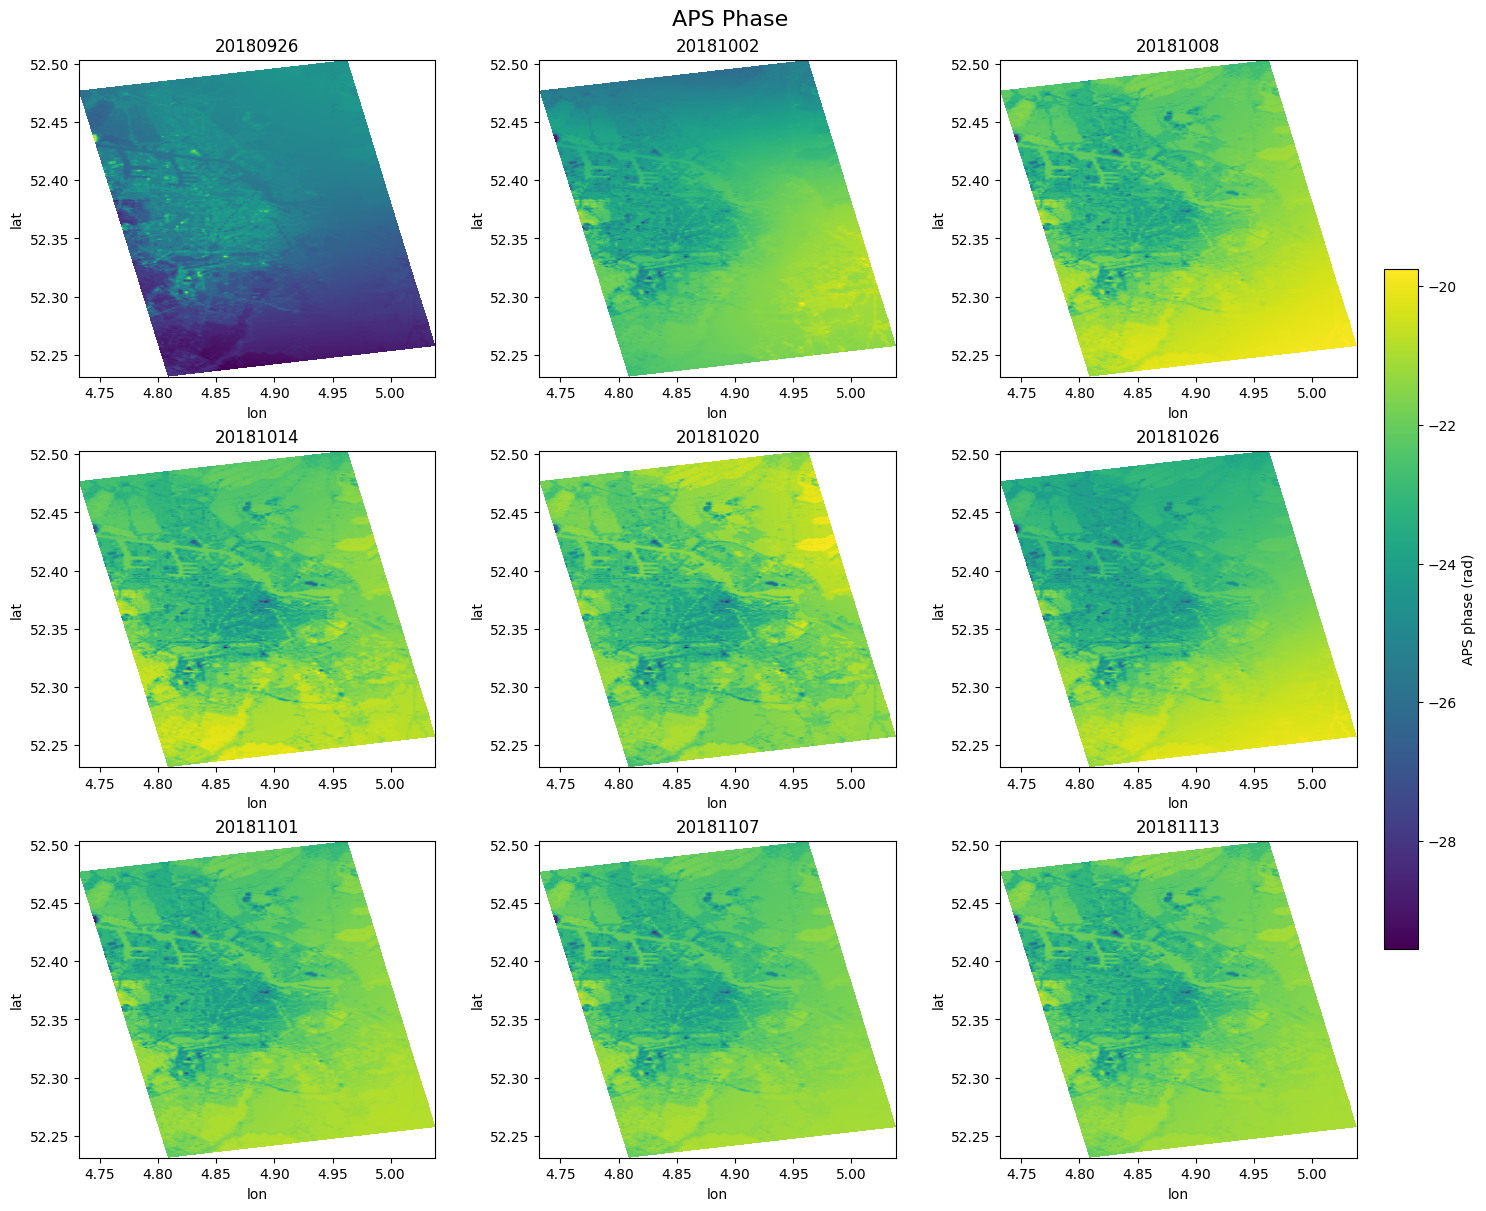

In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Open the Zarr dataset (use consolidated metadata for faster loading)
ds = xr.open_zarr('gacos/aps_all.zarr', consolidated=True)
print(ds)
# Extract the APS phase DataArray
aps = ds['aps_phase']

# Number of slave dates available
n = aps.sizes['slave_date']

# Set number of rows/columns for subplot grid
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 12), constrained_layout=True)

last_im = None  # to store the last image object for colorbar reference

# Loop through each subplot position
for i, ax in enumerate(axes.ravel()):
    if i < n:
        # Plot using lon/lat as x/y coordinates
        im = aps.isel(slave_date=i).plot(
            ax=ax,
            add_colorbar=False,  # disable individual colorbars
            x='lon', y='lat'    # use geographic coordinates

        )
        # Set subplot title as the date string
        ax.set_title(str(ds.slave_date.values[i]))
        # Optional: keep aspect ratio equal so degrees are not distorted
        ax.set_aspect('equal', adjustable='box')
        # Save the last plotted image for colorbar creation
        last_im = im
    else:
        # Turn off unused subplot axes
        ax.axis('off')

# Create a single colorbar for all subplots
if last_im is not None:
    cbar = fig.colorbar(
        last_im,
        ax=axes.ravel().tolist(),
        fraction=0.025,  # size of colorbar relative to figure
        pad=0.02         # spacing from the plots
    )
    cbar.set_label('APS phase (rad)')

# Set an overall figure title
fig.suptitle('APS Phase', fontsize=16)

# Display the figure
plt.show()
